# Ensemble learning 
## 2nd best submission for Entropy, 74.47% accuracy

In [568]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import seaborn as sns
from copy import deepcopy, copy
from PIL import Image
from os import listdir
from torchvision.transforms import Compose, ToPILImage, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import pandas as pd
from livelossplot import PlotLosses
from pycm import *
import torchvision.models as models
import seaborn as sn; sns.set()
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import scipy.interpolate
import itertools

In [569]:
!pip install pycm livelossplot
%pylab inline

You should consider upgrading via the '/opt/firedrake/bin/python -m pip install --upgrade pip' command.
Populating the interactive namespace from numpy and matplotlib


/opt/firedrake/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'Normalize', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [570]:
'''
HYPER-PARAMETERS
'''
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 64
n_epochs = 30
img_mean, img_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225);
img_size = 224

In [571]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True
set_seed(seed)
device = 'cuda' if (torch.cuda.device_count() > 0 and torch.cuda.is_available()) else 'cpu'
device = 'cpu' # default to cpu
print(device)
path = 'all/'

cpu


## Mobilenet (fine-tuned, 64x64)

In [350]:
m_n = models.mobilenet_v2(pretrained=False).to(device)
m_n.classifier=nn.Linear(in_features=1280,out_features=200,bias=True)
m_n.load_state_dict(torch.load("./models/mobilenet_v2_classifier.pth"))
m_n.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

## Googlenet (fine-tuned, 224x224)

In [351]:
g_n = torch.load("./models/googlenet_224.pt") 
g_n = g_n.to(device)

## Densenet121 (fine-tuned, 224x224)

In [495]:
d_n121 = models.densenet121(pretrained=False).to(device)
d_n121.classifier = nn.Linear(in_features=1024, out_features=200, bias=True)
d_n121.load_state_dict(torch.load("./models/Dense121_3_classifier.pt")) #Dense121_3_classifier.pt
d_n121.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Resnet 18 (fine-tuned, 224x224)

In [531]:
rs_18 = models.resnet18(False)
num_ftrs = rs_18.fc.in_features
rs_18.fc = nn.Linear(num_ftrs, 200)
rs_18.load_state_dict(torch.load("./models/Res18_6_classifier.pt"))#./all/224_resnet18_param.pth
rs_18 = rs_18.to(device)

## Renet 50 (fine-tuned, 224x224)

In [524]:
rs_50 = models.resnet50(pretrained=False)
in_ftrs = rs_50.fc.in_features
rs_50.fc = nn.Linear(in_ftrs, 200).to(device)
rs_50.load_state_dict(torch.load(F"./models/Res50_4_classifier_NF.pt"))
#rs_50 = torch.load("Res50_4_classifier_NF.pt") 
rs_50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Wide Resnet50 (fine-tuned, 224x224)

In [518]:
w_rs_50 = models.wide_resnet50_2(pretrained = False)
num_ftrs = w_rs_50.fc.in_features
w_rs_50.fc = nn.Linear(num_ftrs, 200) 
w_rs_50.load_state_dict(torch.load("./models/W_ResNet50_224_min_aug_SGD.pth"))#./all/224_resnet18_param.pth
w_rs_50 = w_rs_50.to(device)

## Resnet-152

In [509]:
rs_152 = models.resnet152(pretrained=False)                                                                    

rs_152.fc=nn.Linear(in_features=2048,out_features=200,bias=True)

rs_152.load_state_dict(torch.load("./models/resnet152.pt"))

rs_152.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [355]:
imagenet = datasets.ImageFolder(root=F'{path}/train/')
# Convert label codes into numbers
with open(F'{path}/mapping.json') as f:
    mapping = json.load(f)


labels = [mapping[filename[0].split('/')[-3]] for filename in imagenet.samples]
print(labels[0:-1:500])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


# Data processing and set-up

In [572]:
class TinyImageNet(Dataset):
    def __init__(self, data, targets, transform=None, resize=False, size=64):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform
        self.resize = resize
        self.size = int(size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = Image.open(sample[0])
        sample = np.asarray(sample, dtype=np.float32)/255.
        if self.resize:
            sample = cv2.resize(np.asarray(sample), (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        
        if sample.ndim == 2:
            tmp = np.zeros((self.size, self.size, 3), dtype=np.float32)
            for c in range(3):
                tmp[:,:,c] = sample
            sample = tmp
            
        sample = ToTensor()(sample)
        if self.transform:
            # Apply transformations on-the-fly
            sample = self.transform(sample)

        return sample, label
    
class TinyImageNetTest(Dataset):
    def __init__(self, data, transform=None, resize=True, size=224):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.transform = transform
        self.resize = resize
        self.size = int(size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = Image.open(sample[0])
        sample = np.asarray(sample, dtype=float)/255.
        if self.resize:
            sample = cv2.resize(np.asarray(sample), (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        
        if sample.ndim == 2:
            tmp = np.zeros((img_size, img_size, 3), dtype=float)
            for c in range(3):
                tmp[:,:,c] = sample
                
            sample = tmp
        if self.transform:
            # Apply transformations on-the-fly
            sample = self.transform(sample)

        return sample

In [573]:
def validate(model, criterion, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            loss = criterion(a2, y)           # Calculate BCE Loss
            validation_loss += loss*X.size(0) # Accumulate loss over batch
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            # Accumulate accuracy over batch.
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    # Return training loss and accuracies normalized by the dataset size
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    ys, y_preds = [], []  # Keep track of what predictions and labels
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            ys.append(y.cpu().numpy())                  # Get actual class and append to ground truth list
            y_preds.append(y_pred.cpu().numpy())        # Append to predictions list
    # Return predictions and ground truths list
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

def predict(model, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()        # Set to evaluation mode to avoid learning procedures in model
    y_preds = []    # Keep track of what predictions and labels
    for X in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X = X.to(device)                  # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            y_preds.append(y_pred.cpu().numpy())        # Append to predictions list
    # Return predictions and ground truths list
    return np.concatenate(y_preds, 0)

In [574]:
def validate_confusion(model, criterion, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    y_ = []
    a2_ = []
    x_ = []
    count = 0 
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model       
            loss = criterion(a2, y)           # Calculate BCE Loss
            validation_loss += loss*X.size(0) # Accumulate loss over batch
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            
            plt.plot( np.sort(F.softmax(a2, dim=0)[0].numpy()), markevery = 10)
            plt.xlim(190, 200)
            #x_.append(X) 
            #y_.append(y) # return label
            #a2_.append(y_pred) # and prediction
            
            count +=1
            if count == 15: break

            # Accumulate accuracy over batch.
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    # Return training loss and accuracies normalized by the dataset size
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

## Training and validation sets (via stratified random shuffling), mild data augmentation

In [575]:
# Define stratified shuffling item
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed).split(imagenet.samples, labels)
# Collect indices arrays that represent which samples are assigned as training or validation.
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
X_val, y_val = np.array(imagenet.samples)[indices[1]].tolist(), np.array(labels)[indices[1]].tolist()

imagenet_transforms = Compose([transforms.ToPILImage(), transforms.RandomRotation(10), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(img_mean, img_std)])
imagenet_val = TinyImageNet(X_val, y_val, transform=imagenet_transforms, resize=True, size=img_size)
# Define our dataloaders for each set, seting num_workers to 4 to call 4 threads to do task of loading
# and transforming data.
val_loader = DataLoader(imagenet_val, batch_size=test_batch_size, 
                          shuffle=False, num_workers=0)   # No need to shuffle as no learning will occur on these


## Test set

In [576]:
imagenet_test = datasets.ImageFolder(root=F'{path}/test/')
X_test = np.array(imagenet_test.samples)[:].tolist()
imagenet_transforms = Compose([transforms.ToTensor(), transforms.Normalize(img_mean, img_std)])
imagenet_test = TinyImageNetTest(X_test, transform=imagenet_transforms, resize=True, size=img_size)
tags = [filename[0].split('\\')[-1].lower() for filename in imagenet_test.data]

# Define our dataloaders for each set, seting num_workers to 4 to call 4 threads to do task of loading
# and transforming data.
test_loader = DataLoader(imagenet_test, batch_size=64, 
                          shuffle=False, num_workers=0)    # Training set shuffled on every epoch

criterion = nn.CrossEntropyLoss()

## Densenet121 (224x224) accuracy

In [ ]:
# CHECK LOSS AND ACCURACY: BEST ACCURACY ON 64X64 INPUTS
loss, acc = validate(d_n121, criterion, val_loader)
print("="*30)
print("Loss = %.3f \t || \t Accuracy = %.3f" % (loss, acc))
print("="*30)

## Mobilenet (64x64) accuracy

In [ ]:
# CHECK LOSS AND ACCURACY: BEST ACCURACY ON 64X64 INPUTS
loss, acc = validate(m_n, criterion, val_loader)
print("="*30)
print("Loss = %.3f \t || \t Accuracy = %.3f" % (loss, acc))
print("="*30)

## Resnet18 (224x224) accuracy

In [ ]:
# CHECK LOSS AND ACCURACY: BEST ACCURACY ON 64X64 INPUTS
loss, acc = validate(rs_18, criterion, val_loader)
print("="*30)
print("Loss = %.3f \t || \t Accuracy = %.3f" % (loss, acc))
print("="*30)

## Googlenet (224x224) accuracy - Warning

### Need to use a different data loader to obtain an accurate figure

In [ ]:
# CHECK LOSS AND ACCURACY: BEST ACCURACY ON 224X224 INPUTS
loss, acc = validate(g_n, criterion, val_loader)
print("="*30)
print("Loss = %.3f \t || \t Accuracy = %.3f" % (loss, acc))
print("="*30)

## Resnet50 (224x224) accuracy

In [ ]:
# CHECK LOSS AND ACCURACY: BEST ACCURACY ON 224X224 INPUTS
loss, acc = validate(rs_50, criterion, val_loader)
print("="*30)
print("Loss = %.3f \t || \t Accuracy = %.3f" % (loss, acc))
print("="*30)

# Make predictions on test set

In [362]:
y_pred_d_n121 = predict(d_n121, test_loader)

In [369]:
y_pred_m_n = predict(m_n, test_loader)

In [363]:
y_pred_rs_18 = predict(rs_18, test_loader)

In [364]:
y_pred_rs_50 = predict(rs_50, test_loader)

In [365]:
y_pred_g_n = predict(g_n, test_loader)

# Final predictions - Combines WideResnet50, Resnet18, Resnet152, Densenet121

In [577]:
#wideresnet50
y_pred_w_rs_50 = predict(w_rs_50, test_loader)

In [578]:
#resnet18
y_pred_rs_18 = predict(rs_18, test_loader)

In [579]:
#resnet152
y_pred_rs_152 = predict(rs_152, test_loader)

In [580]:
y_pred_d_n121 = predict(d_n121, test_loader)

In [597]:
# put all predictions into a dataframe
all_models = pd.DataFrame({'Wideresnet50': y_pred_rs_50, 'Resnet152': y_pred_g_n, 'ResNet18': y_pred_rs_18, 'DenseNet121': y_pred_d_n121})

In [598]:
all_models[10:20] # show hot it looks like

,Wideresnet50,Resnet152,ResNet18,DenseNet121
10,63,63,63,63
11,107,107,176,107
12,88,5,106,88
13,11,11,11,11
14,42,42,42,42
15,51,51,51,51
16,23,23,23,23
17,167,167,167,167
18,78,78,78,78
19,8,195,139,195


In [599]:
all_models.to_csv(r'./all_models.csv') # save into csv

# Cross-correlation of the PDFs of the output classes

We seek low correlations - The lower, the better the models will complement each other.

In [600]:
all_models.corr() # calculate cross correlation matrix

,Wideresnet50,Resnet152,ResNet18,DenseNet121
Wideresnet50,1.000000,0.784089,0.752025,0.752950
Resnet152,0.784089,1.000000,0.733140,0.732353
ResNet18,0.752025,0.733140,1.000000,0.725898
DenseNet121,0.752950,0.732353,0.725898,1.000000


# Hard voting algorithm

In [601]:
ensemble = []
votes = []

for index, row in all_models.iterrows():    
    uniq, cnt = np.unique(row.values, return_counts=True)# values and how many of each
    if (np.amax(cnt) != 1):
        ensemble.append(uniq[np.argmax(cnt)])
    else:
        ensemble.append(row.values[0]) # if we are going to guess, at least do so with the most accurate model!!!
    votes.append(np.amax(cnt))
print(len(ensemble))

10000


## Class votes frequency distribution

Text(0, 0.5, 'Frequency')

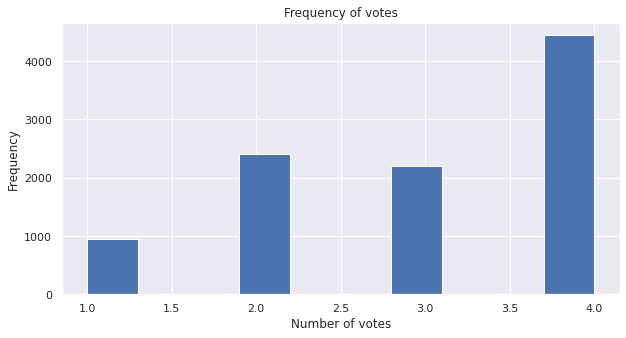

In [602]:
sn.set(rc={'figure.figsize':(10,5)})
plt.hist(votes)
plt.title('Frequency of votes')
plt.xlabel('Number of votes')
plt.ylabel('Frequency')

In [603]:
votes = np.array(votes) # convert to numpy arrays for ease of handling
ensemble = np.array(ensemble)

Let us look into the distribution of the classes the classifiers do not agree on. 

In [604]:
indices = np.where(votes == 1) # 

## When all models disagree - Frequency distribution

Text(0, 0.5, 'Number of times a class was guessed')

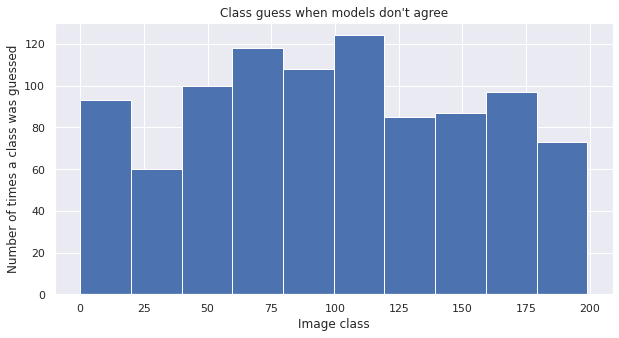

In [605]:
plt.hist(ensemble[indices], bins=10)
plt.title("Class guess when models don't agree")
plt.xlabel('Image class')
plt.ylabel('Number of times a class was guessed')

In [606]:
ensemble_pd = pd.DataFrame({'Ensemble output': ensemble})

Let us see how the output of the voting algorithm compares to the output of the models. 

In [607]:
print(all_models[20:30], ensemble_pd[20:30])

    Wideresnet50  Resnet152  ResNet18  DenseNet121
20            85         85        85           85
21            66        195        66          194
22            27         27        27           27
23           170        170       170          129
24            66          4       168          118
25            45         36        38          183
26            71         71        71           71
27            35         35        35           35
28            69         69        69           69
29            51         33        51           51     Ensemble output
20               85
21               66
22               27
23              170
24               66
25               45
26               71
27               35
28               69
29               51


It seems to behave as expected. 

In [608]:
ensemble_pd.to_csv(r'./Ensemble_output.csv') #save it

In [609]:
#let us do a sanity check by loading a benchmark
# and finding correlation with ensemble
submission = pd.read_csv('./output/Entropy_W_ResNet50_224_min_aug_SGD.csv') # let us correlate the output to a 60% benchmark to ensure nothing went wrong

In [610]:
submission['Label'].corr(ensemble_pd['Ensemble output']) # correlation between benchmark and ensemble guess

0.8397286294050028

That correlation seems sensible, proceed with submission.

## Is the output of the ensemble equilibrated?

Text(0, 0.5, 'Number of times a class was guessed')

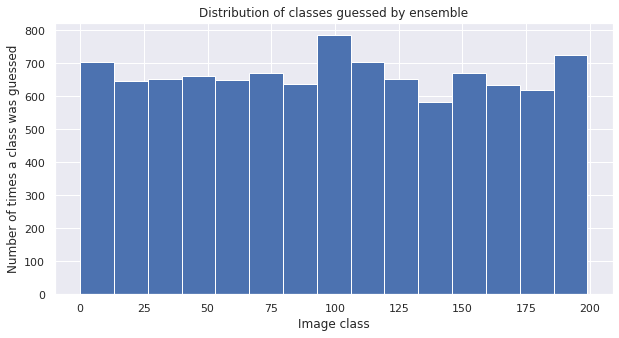

In [611]:
plt.hist(ensemble_pd['Ensemble output'], bins = 15) # Distribution of output classes
plt.title("Distribution of classes guessed by ensemble")
plt.xlabel('Image class')
plt.ylabel('Number of times a class was guessed')

In [614]:
all_models

,Wideresnet50,Resnet152,ResNet18,DenseNet121
0,107,107,107,107
1,40,139,159,49
2,158,100,139,158
3,90,175,161,90
4,80,138,104,80
...,...,...,...,...
9995,92,92,92,147
9996,153,153,153,94
9997,37,106,106,173
9998,1,1,1,1


[Text(0.5, 0, 'Class'), Text(0.5, 1.0, 'DenseNet121')]

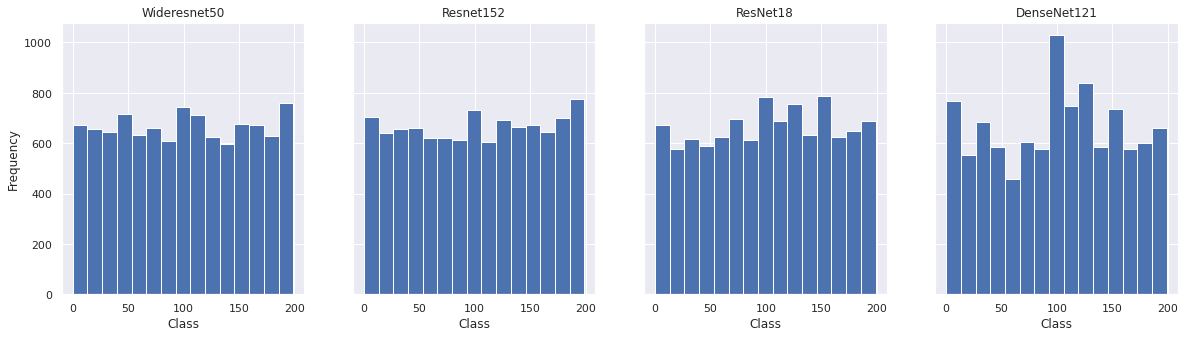

In [616]:
sn.set(rc={'figure.figsize':(20,5)})
fig, axs = plt.subplots(1, 4, sharey = True)
axs[0].hist(all_models['Wideresnet50'],  bins=15)
axs[0].set(title = 'Wideresnet50', xlabel = 'Class', ylabel = 'Frequency')
axs[1].hist(all_models['Resnet152'], bins = 15)
axs[1].set(title = 'Resnet152', xlabel = 'Class')
axs[2].hist(all_models['ResNet18'],  bins = 15)
axs[2].set(title = 'ResNet18', xlabel = 'Class')
axs[3].hist(all_models['DenseNet121'],  bins = 15)
axs[3].set(title = 'DenseNet121', xlabel = 'Class')

As the plots above suggest, the distribution of the output of the ensemble is smoother. 

# Confusion matrix

Finding the confusion matrix of the 200 classes might show different patterns of misclassification. 

In [617]:
# create a load that contains the validation set (suited for loading into the predict function)
X_test_2 =X_val
imagenet_transforms = Compose([transforms.ToTensor(), transforms.Normalize(img_mean, img_std)])
imagenet_test = TinyImageNetTest(X_test_2 , transform=imagenet_transforms, resize=True, size=img_size)
tags = [filename[0].split('\\')[-1].lower() for filename in imagenet_test.data]

# Define our dataloaders for each set, seting num_workers to 4 to call 4 threads to do task of loading
# and transforming data.
test_2_loader = DataLoader(imagenet_test, batch_size=64, 
                          shuffle=False, num_workers=0)    # Training set shuffled on every epoch


In [ ]:
y_prediction = predict(rs_50, test_2_loader)

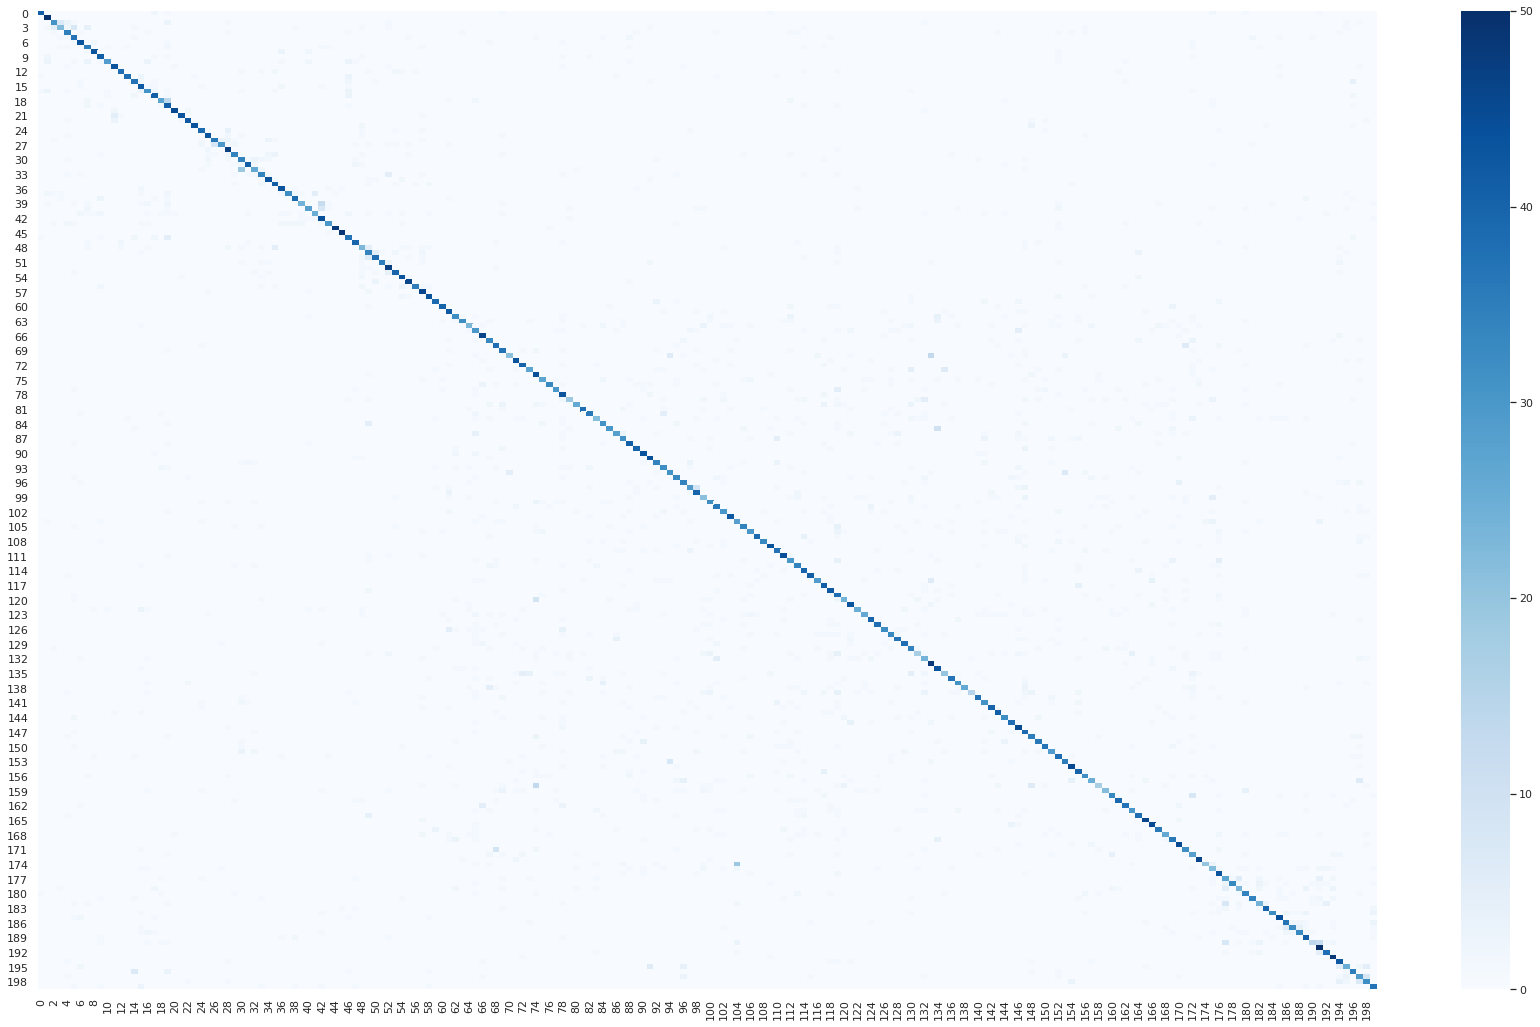

In [619]:
m = confusion_matrix(y_val, y_prediction);# m = m.astype('float64') 
sn.set(rc={'figure.figsize':(30,18)})
sn.heatmap(m, cmap='Blues')

There are no apparent patterns of misclassifications.

# Finding an optimal ensemble by measuring accuracy on the validation set (10% of training data)

In [498]:
X_test=  X_val
imagenet_transforms = Compose([transforms.ToTensor(), transforms.Normalize(img_mean, img_std)])
imagenet_test = TinyImageNetTest(X_test, transform=imagenet_transforms, resize=True, size=img_size)
tags = [filename[0].split('\\')[-1].lower() for filename in imagenet_test.data]

# Define our dataloaders for each set, seting num_workers to 4 to call 4 threads to do task of loading
# and transforming data.
test_loader = DataLoader(imagenet_test, batch_size=64, 
                          shuffle=False, num_workers=0)    # Training set shuffled on every epoch

criterion = nn.CrossEntropyLoss()

### Densenet121

In [500]:
y_d_n121 = predict(d_n121, test_loader)
y_d_n121_acc = accuracy_score(y_val, y_d_n121)
print(y_d_n121_acc)

### Mobilenet

In [488]:
#get prediction from each model
y_m_n = predict(m_n, test_loader)
y_m_n_acc = accuracy_score(y_val, y_m_n)
print(y_m_n_acc)

### Resnet18

In [532]:
y_rs_18 = predict(rs_18, test_loader)
y_rs_18_acc = accuracy_score(y_val, y_rs_18)
print(y_rs_18_acc)

0.8851


### Resnet50

In [525]:
y_rs_50 = predict(rs_50, test_loader)
y_rs_50_acc = accuracy_score(y_val, y_rs_50)
print(y_rs_50_acc)

0.7195


### Googlenet

In [527]:
y_g_n = predict(g_n, test_loader)
y_g_n_acc = accuracy_score(y_val, y_g_n)
print(y_g_n_acc)

0.6871


### Resnet152

In [514]:
y_rs_152 = predict(rs_152, test_loader)
y_rs_152_acc = accuracy_score(y_val, y_rs_152)
print(y_rs_152_acc)

### WideResnet50

In [519]:
y_w_rs_50 = predict(w_rs_50, test_loader)
y_w_rs_50_acc = accuracy_score(y_val, y_w_rs_50)
print(y_w_rs_50_acc)

0.8105


In [529]:
# create dataframe with accuracies
all_accuracies = pd.DataFrame({'DenseNet121': [y_d_n121_acc],  'MobileNet': [y_m_n_acc], 'ResNet18': [y_rs_18_acc],  'Resnet50': [y_rs_50_acc],  'GoogleNet': [y_g_n_acc], 'Resnet152': [y_rs_152_acc], 'Wideresnet50': [y_w_rs_50_acc]})

## Model accuracies on validation set

In [561]:
all_accuracies

,DenseNet121,MobileNet,ResNet18,Resnet50,GoogleNet,Resnet152,Wideresnet50
0,0.679,0.5318,0.8851,0.7195,0.6871,0.8178,0.8105


## Creating the ensemble

In [534]:
# order models by increasing accuracy - model in position 0 is picked by default when all models disagree
all_models = pd.DataFrame({ 'Wideresnet50': y_w_rs_50, 'Resnet152': y_rs_152,  'ResNet18': y_rs_18, 'DenseNet121': y_d_n121,  'MobileNet': y_m_n, 'Resnet50': y_rs_50,  'GoogleNet': y_g_n })

In [624]:
all_models.head()

,Wideresnet50,Resnet152,ResNet18,DenseNet121
0,107,107,107,107
1,40,139,159,49
2,158,100,139,158
3,90,175,161,90
4,80,138,104,80


In [537]:
# check ensemble accuracy
def calculate_ensemble(all_models):
    ensemble = []
    votes = []
    for index, row in all_models.iterrows():    
        uniq, cnt = np.unique(row.values, return_counts=True)# values and how many of each
        if (np.amax(cnt) != 1):
            ensemble.append(uniq[np.argmax(cnt)])
        else:
            ensemble.append(row.values[0]) # if we are going to guess, at least do so with the most accurate model!!!
        votes.append(np.amax(cnt))
    return ensemble

In [621]:
ensemble = calculate_ensemble(all_models)

# Cross correlation between models

In [567]:
all_models.corr()

,Wideresnet50,Resnet152,ResNet18,DenseNet121,MobileNet,Resnet50,GoogleNet
Wideresnet50,1.000000,0.821713,0.850133,0.779420,0.704645,0.797335,0.806826
Resnet152,0.821713,1.000000,0.853782,0.771841,0.676919,0.805342,0.763066
ResNet18,0.850133,0.853782,1.000000,0.785931,0.702329,0.817098,0.783013
DenseNet121,0.779420,0.771841,0.785931,1.000000,0.660138,0.756207,0.743067
MobileNet,0.704645,0.676919,0.702329,0.660138,1.000000,0.660096,0.694573
Resnet50,0.797335,0.805342,0.817098,0.756207,0.660096,1.000000,0.750971
GoogleNet,0.806826,0.763066,0.783013,0.743067,0.694573,0.750971,1.000000


## Let's try every possible model combination and check which yields the highest accuracies

In [566]:
indeces = []
stuff = [0, 1, 2, 3, 4, 5, 6]
for L in range(1, len(stuff)+1):
    for subset in itertools.combinations(stuff, L): # generate each possible combination of models 
        subset = np.array(subset)
        indeces.append(subset)
        temp_ensemble = pd.DataFrame(np.zeros((10000,len(subset)))) # create temp dataframe to store ensemble 
        cnt = 0
        for i in subset: 
            temp_ensemble.iloc[:, cnt] = all_models.iloc[:, i]
            ensemble = calculate_ensemble(temp_ensemble)
            acc = accuracy_score(y_val, ensemble)
            cnt += 1
        print("Combination:", subset, "\t", acc)

Combination: [0] 	 0.8105
Combination: [1] 	 0.8178
Combination: [2] 	 0.8851
Combination: [3] 	 0.679
Combination: [4] 	 0.5318
Combination: [5] 	 0.7195
Combination: [6] 	 0.6871
Combination: [0 1] 	 0.8105
Combination: [0 2] 	 0.8105
Combination: [0 3] 	 0.8105
Combination: [0 4] 	 0.8105
Combination: [0 5] 	 0.8105
Combination: [0 6] 	 0.8105
Combination: [1 2] 	 0.8178
Combination: [1 3] 	 0.8178
Combination: [1 4] 	 0.8178
Combination: [1 5] 	 0.8178
Combination: [1 6] 	 0.8178
Combination: [2 3] 	 0.8851
Combination: [2 4] 	 0.8851
Combination: [2 5] 	 0.8851
Combination: [2 6] 	 0.8851
Combination: [3 4] 	 0.679
Combination: [3 5] 	 0.679
Combination: [3 6] 	 0.679
Combination: [4 5] 	 0.5318
Combination: [4 6] 	 0.5318
Combination: [5 6] 	 0.7195
Combination: [0 1 2] 	 0.8931
Combination: [0 1 3] 	 0.8469
Combination: [0 1 4] 	 0.8225
Combination: [0 1 5] 	 0.8479
Combination: [0 1 6] 	 0.8292
Combination: [0 2 3] 	 0.854
Combination: [0 2 4] 	 0.8262
Combination: [0 2 5] 	 0.

### Most accurate model combinations

Combination: [0 1 2]    **Accuracy: 0.8931**

Combination: [0 1 2 3]    **Accuracy:  0.8928**

Combination: [0 1 2 3 5]   **Accuracy:   0.8907**

Combination: [0 1 2 3 6]    **Accuracy:  0.8901**

The 2nd combination is picked as a reasonable compromise between overall accuracy and diversity of models. 

# Further work

The motivation is that most of the times the classifier is not very confident about the class it predicts (as per the diagram below).This might skew the results when using hard voting.
As such, the aim would be to compare the accuracy of soft voting on the validation dataset. 

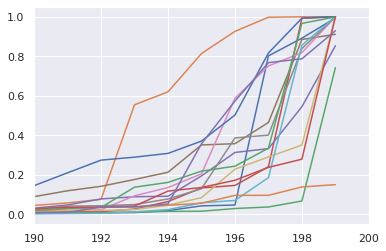

In [461]:
loss, acc = validate_confusion(m_n, criterion, val_loader)
plt.title('Sorted Softmax probabilities of 14 images classifications')
plt.xlabel('Interval of sorted classes with highest softmax probabilities')
plt.ylabel('Softmax probability')

Some key points for further work include:
- Testing ensemble on full the full training set (100%, rather than 10%) or running some form of cross validation such as k-fold.
- Implementing soft voting 
- Exploring the nature of the correlations between different architectures